<a href="https://colab.research.google.com/github/KotrynaVenskunaite/DenjiGoGo/blob/main/Denji_and_Aki_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt

In [1]:
!unzip -q Train.zip
!ls

sample_data  Train  Train.zip


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
) 

Found 62 files belonging to 2 classes.
Using 50 files for training.
Found 62 files belonging to 2 classes.
Using 12 files for validation.


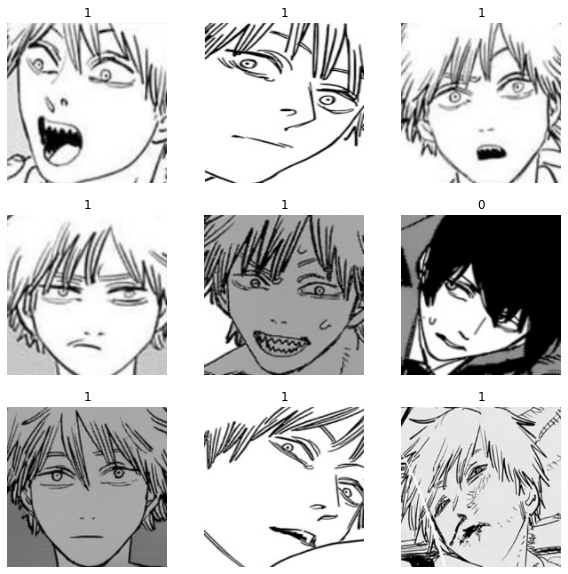

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

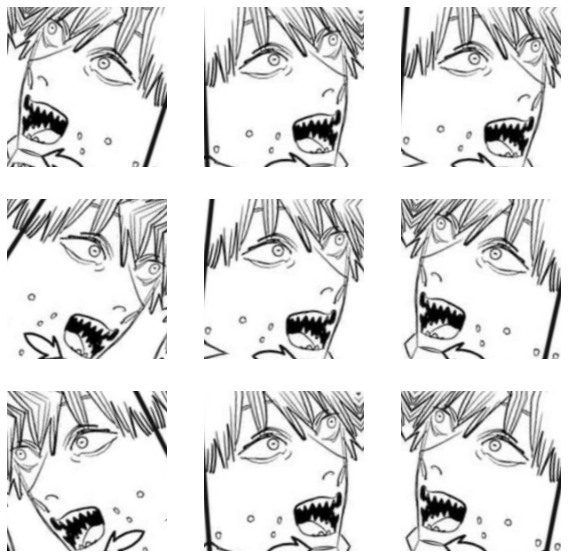

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

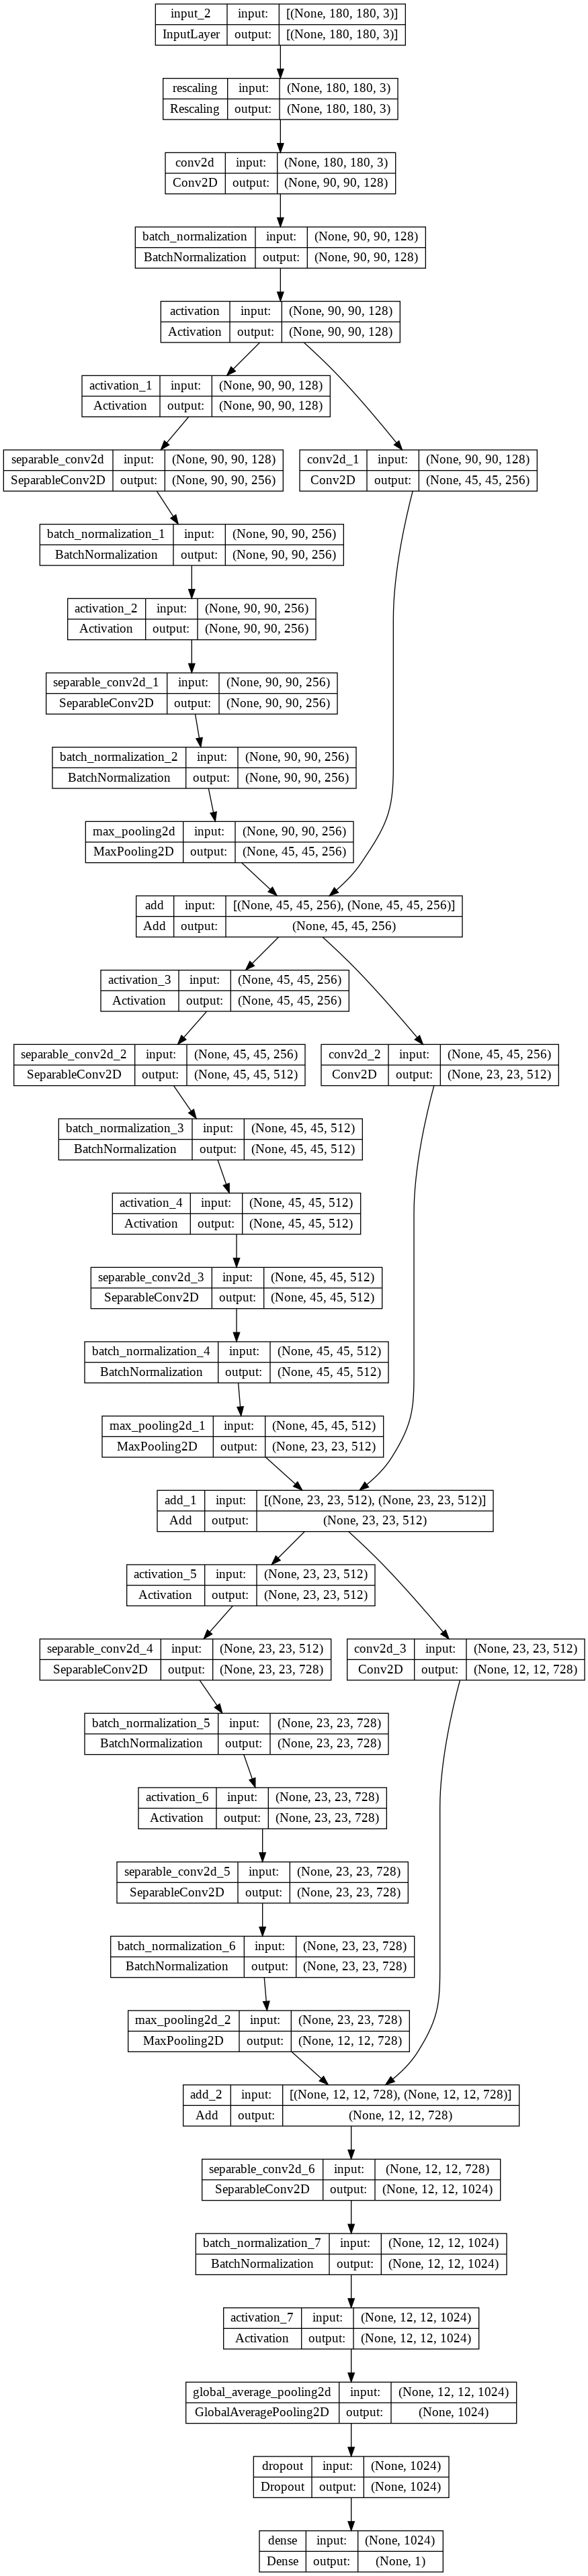

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
1/1 [==============================] - 37s 37s/step - loss: 0.6828 - accuracy: 0.5600 - val_loss: 0.6803 - val_accuracy: 0.9167
Epoch 2/25
1/1 [==============================] - 31s 31s/step - loss: 0.1668 - accuracy: 0.9400 - val_loss: 0.6752 - val_accuracy: 0.9167
Epoch 3/25
1/1 [==============================] - 30s 30s/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.6702 - val_accuracy: 0.9167
Epoch 4/25
1/1 [==============================] - 30s 30s/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.6645 - val_accuracy: 0.9167
Epoch 5/25
1/1 [==============================] - 30s 30s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.6590 - val_accuracy: 0.9167
Epoch 6/25
1/1 [==============================] - 29s 29s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.6538 - val_accuracy: 0.9167
Epoch 7/25
1/1 [==============================] - 30s 30s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6488 - val_accuracy: 0.9167
Epoch 8/25
1/1 [===========

In [ ]:
model.save("chainsawman_model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 128)  3584        ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 90, 90, 128)  512        ['conv2d[0][0]']             

In [ ]:
from tensorflow.python.keras.models import load_model



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 128)  3584        ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 90, 90, 128)  512        ['conv2d[0][0]']             

In [ ]:
img = keras.preprocessing.image.load_img(
    "aki.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% Denji and {100 * score:.2f}% Aki.")

1/1 [==============================] - 0s 167ms/step
This image is 43.09% Denji and 56.91% Aki.
